In [101]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests 
from dotenv import load_dotenv
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import cross_val_score
import seaborn as sns
import tensorflow as tf
from retry_requests import retry
import openmeteo_requests
import requests_cache

In [102]:
# read in csv
df = pd.read_csv('nfl_elo.csv')

# getting years from 20219-2022
lst = list(range(2019, 2023))
updated_df = df[df['season'].isin(lst)]

In [103]:
# lst of irrelevant columns
columns_to_drop = ['elo1_post', 'elo2_post', 'qb1_value_pre', 'qb2_value_pre', 'qb1_adj', 'qb2_adj', 
                   'qbelo_prob1', 'qbelo_prob2', 'qb1_game_value', 'qb2_game_value', 'qb1_value_post',
                   'qb2_value_post', 'qbelo1_post', 'qbelo2_post', 'quality', 'importance', 'total_rating', 'playoff'
                   ]

# create the updated dataframe
updated_df = updated_df.drop(columns=columns_to_drop)

# creating win column for binary classification
updated_df['win'] = (updated_df['score1'] > updated_df['score2']).astype(int)

In [104]:
# setting game_id col to index and then resetting index
updated_df['game_id'] = updated_df.index
updated_df.set_index('game_id', inplace=True)
updated_df.reset_index(inplace=True)

In [105]:
# init dictionary 
team_stats = {}

# for average ppg col
def calc_avg(points, games):
    if games == 0:
        return 0
    return points / games

# init columns
updated_df['team1_avg_ppg'] = 0
updated_df['team2_avg_ppg'] = 0
updated_df['team1_avg_ppg_against'] = 0
updated_df['team2_avg_ppg_against'] = 0

# get first season 
season = updated_df.loc[0, 'season']

# setting average points per game, resetting for each new season 
for index, row in updated_df.iterrows():
    if row['season'] != season:
        # get next season and reset the dictionary
        season = updated_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it a new team then add it to dicionary
        team_stats[row['team1']] = {'points': row['score1'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['points'] += row['score1']
        team_stats[row['team1']]['games'] += 1

    # get team1 avg ppg 
    team1_avg_ppg = calc_avg(team_stats[row['team1']]['points'], team_stats[row['team1']]['games'])
    # index it 
    updated_df.at[index, 'team1_avg_ppg'] = int(team1_avg_ppg)
    # same thing for team 2  
    if row['team2'] not in team_stats:
        team_stats[row['team2']] = {'points': row['score2'], 'games': 1}
    else:
        team_stats[row['team2']]['points'] += row['score2']
        team_stats[row['team2']]['games'] += 1
    team2_avg_ppg = calc_avg(team_stats[row['team2']]['points'], team_stats[row['team2']]['games'])
    updated_df.at[index, 'team2_avg_ppg'] = int(team2_avg_ppg) 

In [106]:
# init dictionary 
team_stats = {}

# init columns
updated_df['team1_avg_ppg'] = 0
updated_df['team2_avg_ppg'] = 0
updated_df['team1_avg_ppg_against'] = 0
updated_df['team2_avg_ppg_against'] = 0

# for average ppg col
def calc_avg(value, games):
    if games == 0:
        return 0
    return value / games

# for average ppg against col
def calc_avg_ppg_against(points_against, games):
    if games == 0:
        return 0
    return points_against / games

# get first season 
season = updated_df.loc[0, 'season']

# setting average points per game, resetting for each new season 
for index, row in updated_df.iterrows():
    if row['season'] != season:
        # get next season and reset the dictionary
        season = updated_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'points': row['score1'], 'points_against': row['score2'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['points'] += row['score1']
        team_stats[row['team1']]['points_against'] += row['score2']
        team_stats[row['team1']]['games'] += 1

    # get team1 avg ppg 
    team1_avg_ppg = calc_avg(team_stats[row['team1']]['points'], team_stats[row['team1']]['games'])
    # get team1 avg ppg against
    team1_avg_ppg_against = calc_avg_ppg_against(team_stats[row['team1']]['points_against'], team_stats[row['team1']]['games'])
    # index it 
    updated_df.at[index, 'team1_avg_ppg'] = int(team1_avg_ppg)
    updated_df.at[index, 'team1_avg_ppg_against'] = int(team1_avg_ppg_against)

    # same thing for team 2  
    if row['team2'] not in team_stats:
        team_stats[row['team2']] = {'points': row['score2'], 'points_against': row['score1'], 'games': 1}
    else:
        team_stats[row['team2']]['points'] += row['score2']
        team_stats[row['team2']]['points_against'] += row['score1']
        team_stats[row['team2']]['games'] += 1

    team2_avg_ppg = calc_avg(team_stats[row['team2']]['points'], team_stats[row['team2']]['games'])
    team2_avg_ppg_against = calc_avg_ppg_against(team_stats[row['team2']]['points_against'], team_stats[row['team2']]['games'])
    updated_df.at[index, 'team2_avg_ppg'] = int(team2_avg_ppg)
    updated_df.at[index, 'team2_avg_ppg_against'] = int(team2_avg_ppg_against)


In [107]:
# init dictionary
team_wins = {}

# init cols to 0
updated_df['team1_last_5_win_percentage'] = 0.0
updated_df['team2_last_5_win_percentage'] = 0.0

# get first season 
season = updated_df.loc[0, 'season']

# go through each row of df
for index, row in updated_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = updated_df.loc[index, 'season']
        team_stats = {}
    # set team1 equal to if they won or not 
    if row['team1'] not in team_wins:
        team_wins[row['team1']] = [row['win']]
    else:
        team_wins[row['team1']].append(row['win'])
    # set team2 equal to if they won or not 
    if row['team2'] not in team_wins:
        team_wins[row['team2']] = [1 - row['win']]
    else:
        team_wins[row['team2']].append(1 - row['win'])
    # getting lst 5 wins 
    for team in team_wins:
        team_wins[team] = team_wins[team][-5:]
    # getting percentages
    team1_l5_wp = sum(team_wins[row['team1']]) / len(team_wins[row['team1']])
    team2_l5_wp = sum(team_wins[row['team2']]) / len(team_wins[row['team2']])

    # updating the cols of df 
    updated_df.at[index, 'team1_last_5_win_percentage'] = float(team1_l5_wp)
    updated_df.at[index, 'team2_last_5_win_percentage'] = float(team2_l5_wp)


In [108]:
location_df = pd.read_csv('NFL Stadium Latitude and Longtitude.csv')

# dict for mapping
team_abbreviations = {
    'Titans': 'TEN', 'Giants': 'NYG', 'Steelers': 'PIT', 'Panthers': 'CAR',
    'Ravens': 'BAL', 'Buccaneers': 'TB', 'Colts': 'IND', 'Vikings': 'MIN',
    'Cardinals': 'ARI', 'Chiefs': 'KC', 'Lions': 'DET', 'Jaguars': 'JAX',
    'Falcons': 'ATL', 'Redskins': 'WSH', 'Bills': 'BUF',
    'Patriots': 'NE', 'Bengals': 'CIN', 'Forty-Niners': 'SF', 'Saints': 'NO',
    'Rams': 'LAR', 'Broncos': 'DEN', 'Browns': 'CLE', 'Jets': 'NYJ',
    'Eagles': 'PHI', 'Packers': 'GB', 'Cowboys': 'DAL', 'Chargers': 'LAC',
    'Texans': 'HOU', 'Seahawks': 'SEA', 'Raiders': 'OAK', 'Dolphins': 'MIA',
    'Bears': 'CHI'  # Adding abbreviation for the Chicago Bears
}

# abreviations
location_df['Team'] = location_df['Team'].map(team_abbreviations)

# merging
updated_df = pd.merge(updated_df, location_df[['Team', 'latitude', 'longitude']], left_on='team1', right_on='Team', how='left')

# dropping redundant 
updated_df.drop('Team', axis=1, inplace=True)

In [109]:
# # Setup the Open-Meteo API client with cache and retry on error
# cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
# retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
# openmeteo = openmeteo_requests.Client(session = retry_session)

# url = "https://archive-api.open-meteo.com/v1/archive"


# updated_df["temperature_2m_mean"] = 0
# updated_df["precipitation_sum"] = 0
# updated_df["wind_speed_10m_max"] = 0
# updated_df["snowfall_sum"] = 0

# for index, row in updated_df.iterrows():
# 	date = row['date']
# 	latitude = float(row['latitude'])
# 	longitude = float(row['longitude'])
# 	params = {
# 		"latitude": latitude, 
# 		"longitude": longitude, 
# 		"start_date": date, 
# 		"end_date": date, 
# 		"daily": ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "snowfall_sum"],
# 		"temperature_unit": "fahrenheit",
# 		"wind_speed_unit": "mph",
# 		"precipitation_unit": "inch"
# 	}


# 	responses = openmeteo.weather_api(url, params=params)
# 	# Process first location. Add a for-loop for multiple locations or weather models
# 	response = responses[0]
	
# 	# Process daily data. The order of variables needs to be the same as requested.
# 	daily = response.Daily()
# 	daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
# 	daily_precipitation_sum = daily.Variables(1).ValuesAsNumpy()
# 	daily_wind_speed_10m_max = daily.Variables(2).ValuesAsNumpy()
# 	daily_snowfall_sum = daily.Variables(3).ValuesAsNumpy()


# 	updated_df.at[index, "temperature_2m_mean"] = float(daily_temperature_2m_mean)
# 	updated_df.at[index, "precipitation_sum"] = float(daily_precipitation_sum)
# 	updated_df.at[index, "wind_speed_10m_max"] = float(daily_wind_speed_10m_max)
# 	updated_df.at[index, "snowfall_sum"] = float(daily_snowfall_sum)

In [110]:
# total_score_all = updated_df['score1'] + updated_df['score2']
# league_average_score = total_score_all.mean()
# print(f'League average ppg: {league_average_score}')

# total_score = updated_df.loc[updated_df['wind_speed_10m_max'] > 30, 'score1'] + updated_df.loc[updated_df['wind_speed_10m_max'] > 30, 'score2']
# average_score = total_score.mean()
# print(f'High Wind affecting league average ppg: {average_score}')

# total_score = updated_df.loc[updated_df['snowfall_sum'] > 1, 'score1'] + updated_df.loc[updated_df['snowfall_sum'] > 1, 'score2']
# average_score = total_score.mean()
# print(f'Heavy Snow league average ppg: {average_score}')

# total_score = updated_df.loc[updated_df['temperature_2m_mean'] < 0, 'score1'] + updated_df.loc[updated_df['temperature_2m_mean'] < 0, 'score2']
# average_score = total_score.mean()
# print(f'Low Temperature league average ppg: {average_score}')


# # trying to create weather 'score' - work in progress
# updated_df['weather_index'] = 0

# for index, row in updated_df.iterrows():
#     curr_temperature = row['temperature_2m_mean']
#     curr_precip = row['precipitation_sum']
#     curr_wind= row['wind_speed_10m_max']
#     weather_index = 0

#     if curr_wind > 20:
#         weather_index += 1
#     if curr_precip > 1:
#         weather_index += 1
#     if curr_temperature < 20:
#         weather_index += 1
    
#     updated_df.at[index, "weather_index"] = int(weather_index)

In [111]:
nfl_team_stats_df = pd.read_csv('nfl_team_stats_2002-2023.csv')

nfl_team_stats_df = nfl_team_stats_df[nfl_team_stats_df['season'].isin([2019, 2020, 2021, 2022])]


# dict for mapping
team_abbreviations = {
    'Titans': 'TEN', 'Giants': 'NYG', 'Steelers': 'PIT', 'Panthers': 'CAR',
    'Ravens': 'BAL', 'Buccaneers': 'TB', 'Colts': 'IND', 'Vikings': 'MIN',
    'Cardinals': 'ARI', 'Chiefs': 'KC', 'Lions': 'DET', 'Jaguars': 'JAX',
    'Falcons': 'ATL', 'Commanders': 'WSH', 'Bills': 'BUF',
    'Patriots': 'NE', 'Bengals': 'CIN', '49ers': 'SF', 'Saints': 'NO',
    'Rams': 'LAR', 'Broncos': 'DEN', 'Browns': 'CLE', 'Jets': 'NYJ',
    'Eagles': 'PHI', 'Packers': 'GB', 'Cowboys': 'DAL', 'Chargers': 'LAC',
    'Texans': 'HOU', 'Seahawks': 'SEA', 'Raiders': 'OAK', 'Dolphins': 'MIA',
    'Bears': 'CHI'  
}

# abreviations
nfl_team_stats_df['home'] = nfl_team_stats_df['home'].map(team_abbreviations)
nfl_team_stats_df['away'] = nfl_team_stats_df['away'].map(team_abbreviations)
nfl_team_stats_df.rename(columns={'home': 'team1', 'away': 'team2'}, inplace=True)


nfl_team_stats_df.columns
merged_df = nfl_team_stats_df.merge(updated_df, on=['season', 'date', 'team1', 'team2'])

In [112]:
new_features = ['first_downs_away', 'first_downs_home']

merged_df['first_downs_away_avg'] = 0.0
merged_df['first_downs_home_avg'] = 0.0
team_stats = {}

season = merged_df.loc[0, 'season']

for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'total_first_downs': row['first_downs_home'], 'games': 1}
    else:
        team_stats[row['team1']]['total_first_downs'] += row['first_downs_home']
        team_stats[row['team1']]['games'] += 1

    home_first_downs_average = calc_avg(team_stats[row['team1']]['total_first_downs'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'first_downs_home_avg'] = home_first_downs_average

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'total_first_downs': row['first_downs_away'], 'games': 1}
    else:
        team_stats[row['team2']]['total_first_downs'] += row['first_downs_away']
        team_stats[row['team2']]['games'] += 1

    away_first_downs_average = calc_avg(team_stats[row['team2']]['total_first_downs'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'first_downs_away_avg'] = away_first_downs_average

merged_df = merged_df.drop(columns=new_features)

In [113]:
new_features = ['third_down_comp_away','third_down_comp_home']
merged_df['third_down_comp_away_avg'] = 0.0
merged_df['third_down_comp_home_avg'] = 0.0
team_stats = {}

season = merged_df.loc[0, 'season']

for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'total_comp': row['third_down_comp_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['total_comp'] += row['third_down_comp_home']
        team_stats[row['team1']]['games'] += 1

    comp_avg = calc_avg(team_stats[row['team1']]['total_comp'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'third_down_comp_home_avg'] = comp_avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'total_comp': row['third_down_comp_away'], 'games': 1}
    else:
        team_stats[row['team2']]['total_comp'] += row['third_down_comp_away']
        team_stats[row['team2']]['games'] += 1

    away_first_downs_average = calc_avg(team_stats[row['team2']]['total_comp'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'third_down_comp_away_avg'] = away_first_downs_average

merged_df = merged_df.drop(columns=new_features)

In [114]:
new_features = ['third_down_att_away', 'third_down_att_home']
merged_df['third_down_att_away_avg'] = 0.0
merged_df['third_down_att_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']

for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'total_att': row['third_down_att_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['total_att'] += row['third_down_att_home']
        team_stats[row['team1']]['games'] += 1

    att_avg = calc_avg(team_stats[row['team1']]['total_att'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'third_down_att_home_avg'] = att_avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'total_att': row['third_down_att_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['total_att'] += row['third_down_att_away']
        team_stats[row['team2']]['games'] += 1

    att_avg = calc_avg(team_stats[row['team2']]['total_att'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'third_down_att_away_avg'] = att_avg

merged_df = merged_df.drop(columns=new_features)

In [115]:
new_features = ['fourth_down_comp_away', 'fourth_down_comp_home']
merged_df['fourth_down_comp_away_avg'] = 0.0
merged_df['fourth_down_comp_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['fourth_down_comp_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['fourth_down_comp_home']
        team_stats[row['team1']]['games'] += 1

    att_avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'fourth_down_comp_home_avg'] = att_avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['fourth_down_comp_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['fourth_down_comp_away']
        team_stats[row['team2']]['games'] += 1

    att_avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'fourth_down_comp_away_avg'] = att_avg

merged_df = merged_df.drop(columns=new_features)

In [116]:
new_features = ['fourth_down_att_away', 'fourth_down_att_home']
merged_df['fourth_down_att_away_avg'] = 0.0
merged_df['fourth_down_att_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['fourth_down_att_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['fourth_down_att_home']
        team_stats[row['team1']]['games'] += 1

    att_avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'fourth_down_att_home_avg'] = att_avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['fourth_down_att_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['fourth_down_att_away']
        team_stats[row['team2']]['games'] += 1

    att_avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'fourth_down_att_away_avg'] = att_avg

merged_df = merged_df.drop(columns=new_features)

In [117]:
new_features = ['plays_away', 'plays_home']
merged_df['plays_away_avg'] = 0.0
merged_df['plays_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['plays_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['plays_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'plays_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['plays_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['plays_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'plays_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [118]:
new_features = ['drives_away', 'drives_home']
merged_df['drives_away_avg'] = 0.0
merged_df['drives_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['drives_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['drives_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'drives_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['drives_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['drives_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'drives_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [119]:
new_features = ['yards_away', 'yards_home']
merged_df['yards_away_avg'] = 0.0
merged_df['yards_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['yards_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['yards_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'yards_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['yards_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['yards_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'yards_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [120]:
new_features = ['pass_comp_away', 'pass_comp_home']
merged_df['pass_comp_away_avg'] = 0.0
merged_df['pass_comp_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['pass_comp_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['pass_comp_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'pass_comp_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['pass_comp_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['pass_comp_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'pass_comp_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [121]:
new_features = ['pass_att_away', 'pass_att_home']
merged_df['pass_att_away_avg'] = 0.0
merged_df['pass_att_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['pass_att_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['pass_att_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'pass_att_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['pass_att_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['pass_att_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'pass_att_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [122]:
new_features = ['pass_yards_away', 'pass_yards_home']
merged_df['pass_yards_away_avg'] = 0.0
merged_df['pass_yards_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['pass_yards_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['pass_yards_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'pass_yards_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['pass_yards_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['pass_yards_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'pass_yards_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [123]:
new_features = ['sacks_num_away', 'sacks_num_home']
merged_df['sacks_num_away_avg'] = 0.0
merged_df['sacks_num_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['sacks_num_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['sacks_num_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'sacks_num_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['sacks_num_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['sacks_num_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'sacks_num_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [124]:
new_features = ['sacks_yards_away', 'sacks_yards_home']
merged_df['sacks_yards_away_avg'] = 0.0
merged_df['sacks_yards_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['sacks_yards_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['sacks_yards_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'sacks_yards_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['sacks_yards_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['sacks_yards_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'sacks_yards_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [125]:
new_features = ['rush_att_away', 'rush_att_home']
merged_df['rush_att_away_avg'] = 0.0
merged_df['rush_att_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['rush_att_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['rush_att_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'rush_att_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['rush_att_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['rush_att_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'rush_att_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [126]:
new_features = ['rush_yards_away', 'rush_yards_home']
merged_df['rush_yards_away_avg'] = 0.0
merged_df['rush_yards_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['rush_yards_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['rush_yards_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'rush_yards_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['rush_yards_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['rush_yards_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'rush_yards_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [127]:
new_features = ['pen_num_away', 'pen_num_home']
merged_df['pen_num_away_avg'] = 0.0
merged_df['pen_num_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['pen_num_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['pen_num_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'pen_num_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['pen_num_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['pen_num_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'pen_num_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [128]:
new_features = ['pen_yards_away', 'pen_yards_home']
merged_df['pen_yards_away_avg'] = 0.0
merged_df['pen_yards_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['pen_yards_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['pen_yards_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'pen_yards_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['pen_yards_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['pen_yards_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'pen_yards_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [129]:
new_features = ['redzone_comp_away', 'redzone_comp_home']
merged_df['redzone_comp_away_avg'] = 0.0
merged_df['redzone_comp_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['redzone_comp_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['redzone_comp_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'redzone_comp_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['redzone_comp_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['redzone_comp_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'redzone_comp_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [130]:
new_features = ['redzone_att_away', 'redzone_att_home']
merged_df['redzone_att_away_avg'] = 0.0
merged_df['redzone_att_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['redzone_att_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['redzone_att_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'redzone_att_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['redzone_att_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['redzone_att_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'redzone_att_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [131]:
new_features = ['fumbles_away', 'fumbles_home']
merged_df['fumbles_away_avg'] = 0.0
merged_df['fumbles_home_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['fumbles_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['fumbles_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'fumbles_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['fumbles_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['fumbles_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'fumbles_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [132]:
new_features = ['interceptions_home', 'interceptions_away']
merged_df['interceptions_home_avg'] = 0.0
merged_df['interceptions_away_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['interceptions_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['interceptions_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'interceptions_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['interceptions_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['interceptions_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'interceptions_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

In [133]:
new_features = ['def_st_td_home', 'def_st_td_away']
merged_df['def_st_td_home_avg'] = 0.0
merged_df['def_st_td_away_avg'] = 0.0
team_stats = {}
season = merged_df.loc[0, 'season']


for index, row in merged_df.iterrows():
    # check if it is a new season 
    if row['season'] != season:
        # get next season and reset the dictionary
        season = merged_df.loc[index, 'season']
        team_stats = {}
    if row['team1'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team1']] = {'feature': row['def_st_td_home'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team1']]['feature'] += row['def_st_td_home']
        team_stats[row['team1']]['games'] += 1

    avg = calc_avg(team_stats[row['team1']]['feature'], team_stats[row['team1']]['games'])

    merged_df.at[index, 'def_st_td_home_avg'] = avg

    if row['team2'] not in team_stats:
        # if it's a new team then add it to the dictionary
        team_stats[row['team2']] = {'feature': row['def_st_td_away'], 'games': 1}
    else:
        # else increment the total score and games played
        team_stats[row['team2']]['feature'] += row['def_st_td_away']
        team_stats[row['team2']]['games'] += 1

    avg = calc_avg(team_stats[row['team2']]['feature'], team_stats[row['team2']]['games'])

    merged_df.at[index, 'def_st_td_away_avg'] = avg

merged_df = merged_df.drop(columns=new_features)

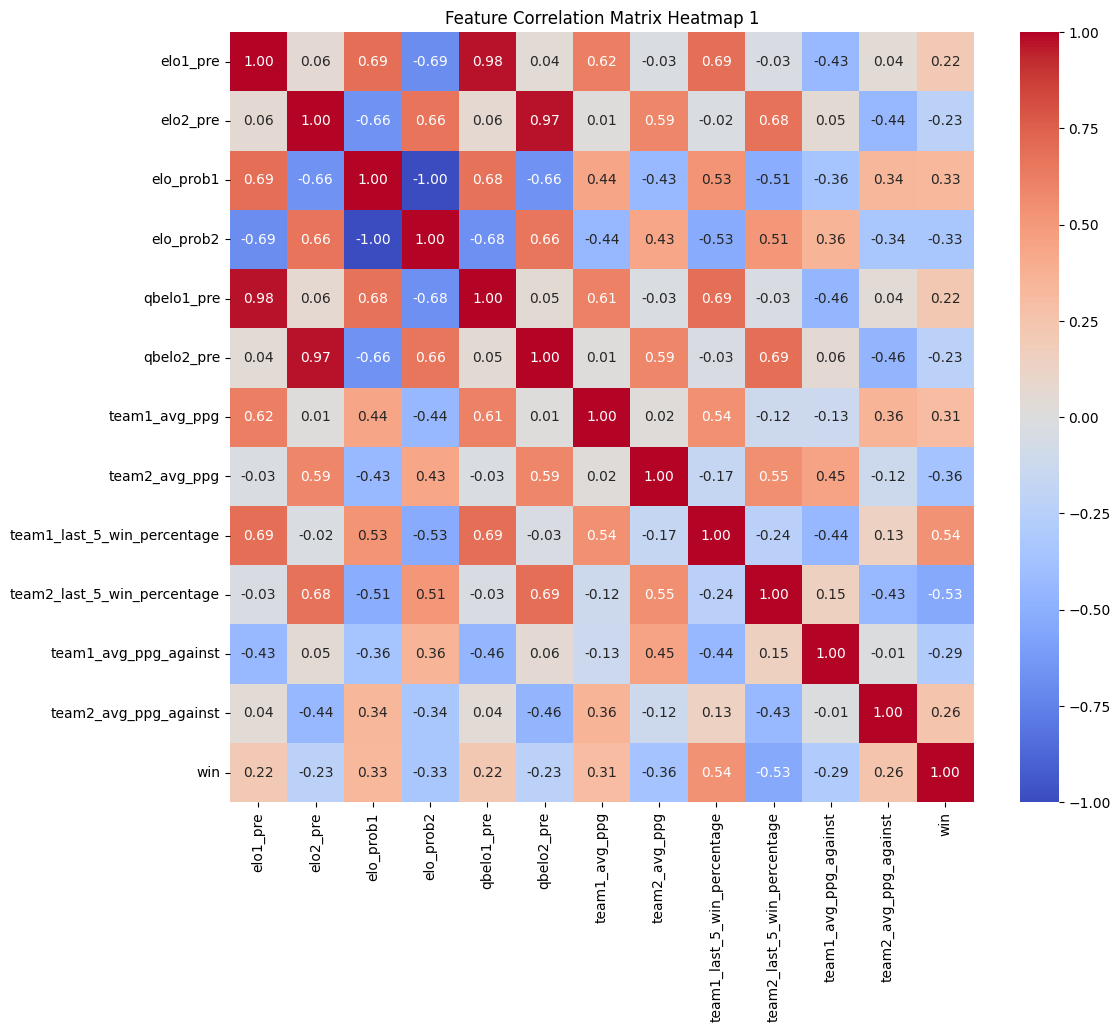

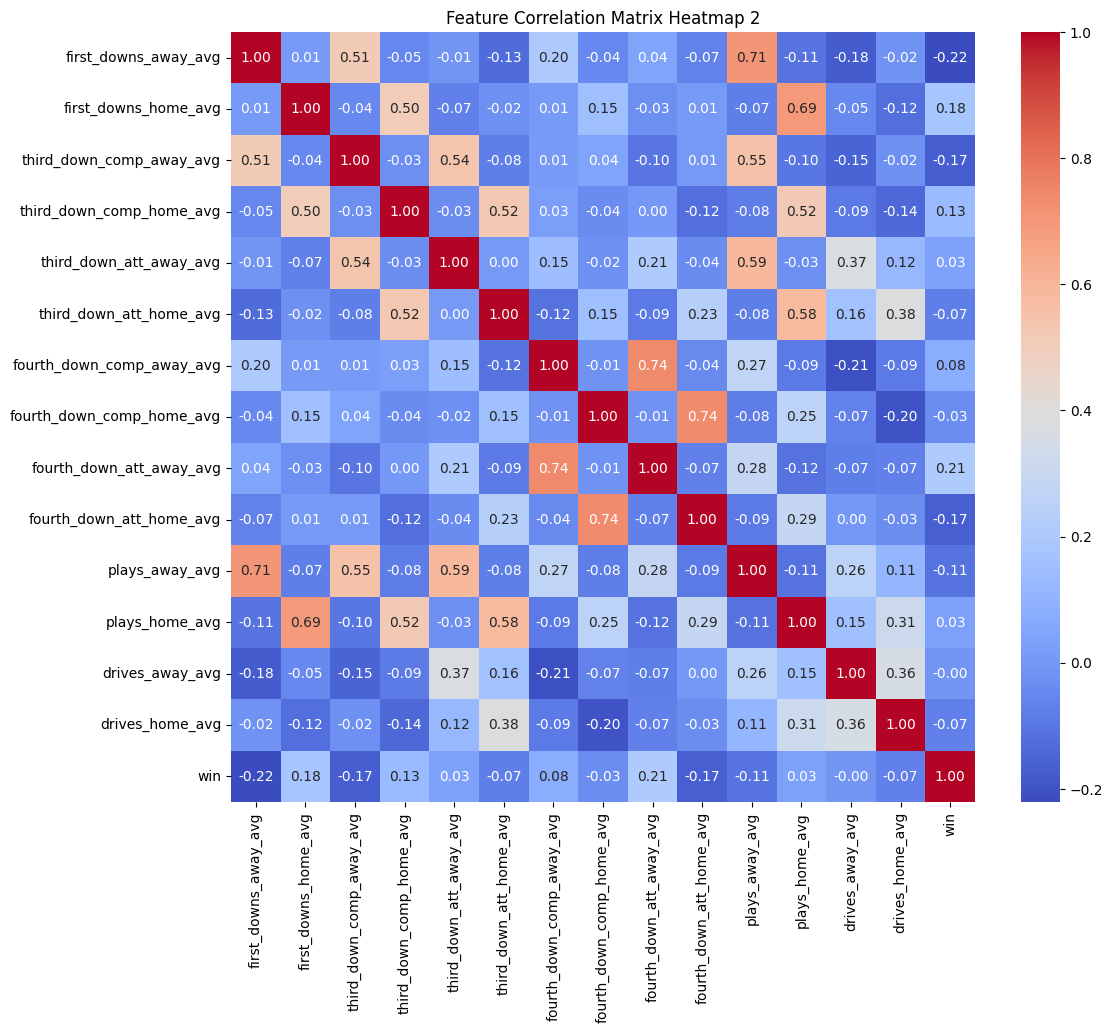

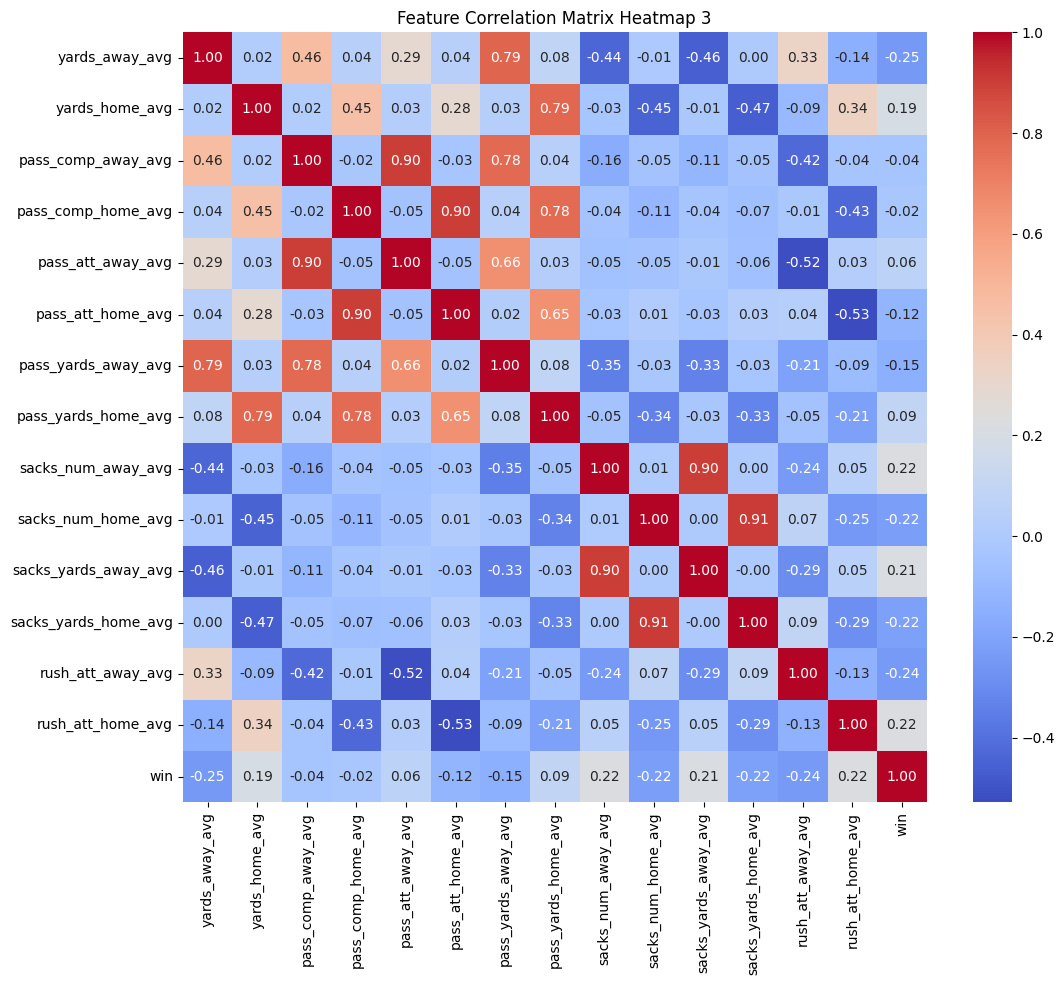

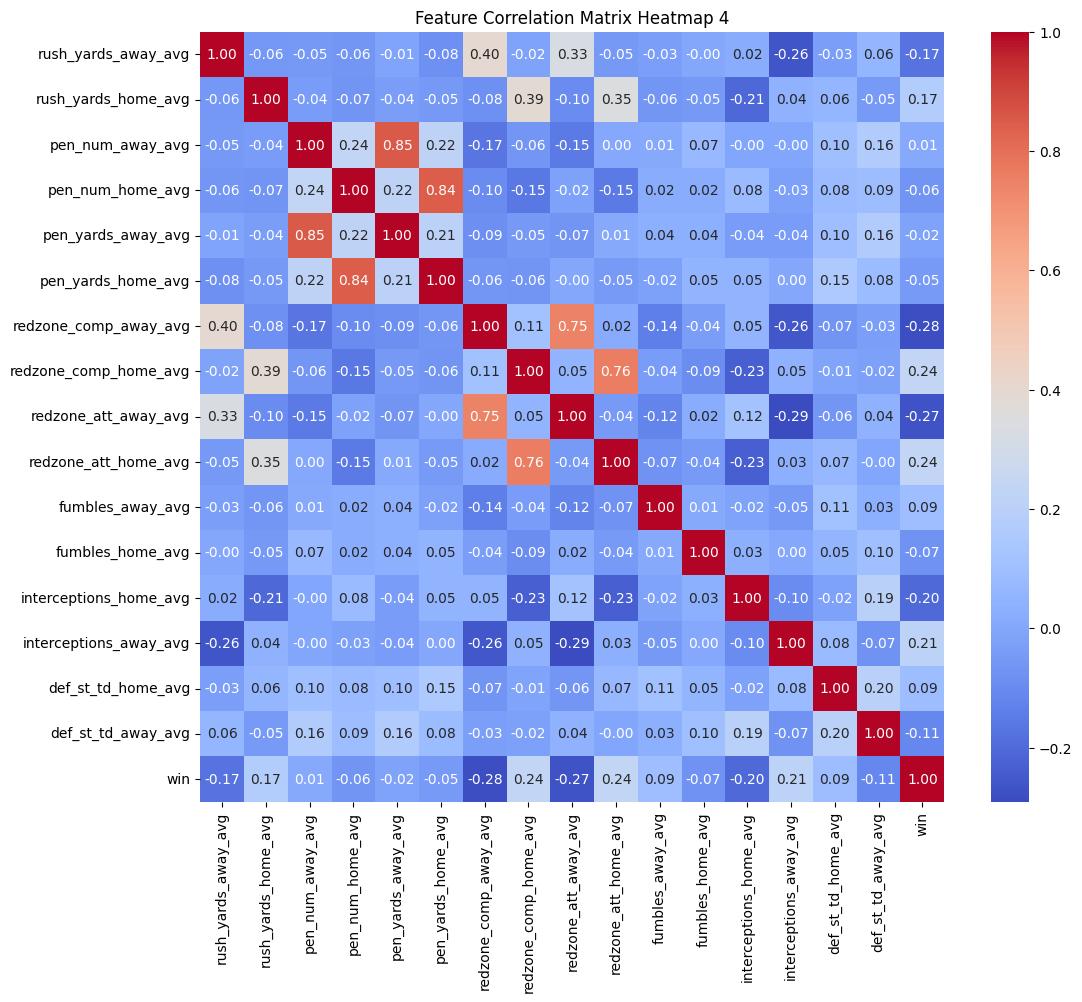

In [164]:
# getting all features that will be used for machine learning model - both X and Y
viz_features1 = ['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'qbelo1_pre', 
                'qbelo2_pre', 'team1_avg_ppg', 'team2_avg_ppg', 'team1_last_5_win_percentage', 
                'team2_last_5_win_percentage', 'team1_avg_ppg_against', 'team2_avg_ppg_against', 'win']

viz_features2 = ['first_downs_away_avg', 'first_downs_home_avg',
       'third_down_comp_away_avg', 'third_down_comp_home_avg',
       'third_down_att_away_avg', 'third_down_att_home_avg',  'fourth_down_comp_away_avg', 'fourth_down_comp_home_avg',
       'fourth_down_att_away_avg', 'fourth_down_att_home_avg', 'plays_away_avg', 'plays_home_avg', 'drives_away_avg',
       'drives_home_avg','win']

viz_features3 = [
        'yards_away_avg', 'yards_home_avg',
       'pass_comp_away_avg', 'pass_comp_home_avg', 'pass_att_away_avg',
       'pass_att_home_avg', 'pass_yards_away_avg', 'pass_yards_home_avg',
       'sacks_num_away_avg', 'sacks_num_home_avg', 'sacks_yards_away_avg',
       'sacks_yards_home_avg', 'rush_att_away_avg', 'rush_att_home_avg', 'win']
       
       
viz_features4 = ['rush_yards_away_avg', 'rush_yards_home_avg', 'pen_num_away_avg',
       'pen_num_home_avg', 'pen_yards_away_avg', 'pen_yards_home_avg',
       'redzone_comp_away_avg', 'redzone_comp_home_avg',
       'redzone_att_away_avg', 'redzone_att_home_avg', 'fumbles_away_avg',
       'fumbles_home_avg', 'interceptions_home_avg', 'interceptions_away_avg',
       'def_st_td_home_avg', 'def_st_td_away_avg', 'win']

viz1 = merged_df[viz_features1]

# getting the correlation matrix 
corr_matrix = viz1.corr()

# plot the heatmap using seaborn 
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix Heatmap 1')
plt.savefig('heatmap1_feature_correlation')
plt.show()


viz2 = merged_df[viz_features2]

# getting the correlation matrix 
corr_matrix = viz2.corr()

# plot the heatmap using seaborn 
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix Heatmap 2')
plt.show()

viz3 = merged_df[viz_features3]

# getting the correlation matrix 
corr_matrix = viz3.corr()

# plot the heatmap using seaborn 
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix Heatmap 3')
plt.show()

viz4 = merged_df[viz_features4]

# getting the correlation matrix 
corr_matrix = viz4.corr()

# plot the heatmap using seaborn 
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix Heatmap 4')
plt.show()

In [136]:
# filtering out week 1
filtered_df = merged_df[merged_df['week'] != '1']

# obtaining X and Y vars
features = ['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'qbelo1_pre', 
            'qbelo2_pre', 'team1_avg_ppg', 'team2_avg_ppg', 'team1_last_5_win_percentage', 
            'team2_last_5_win_percentage', 'team1_avg_ppg_against', 'team2_avg_ppg_against',
            'first_downs_away_avg', 'first_downs_home_avg',
            'third_down_comp_away_avg', 'third_down_comp_home_avg',
            'third_down_att_away_avg', 'third_down_att_home_avg',  'fourth_down_comp_away_avg', 'fourth_down_comp_home_avg',
            'fourth_down_att_away_avg', 'fourth_down_att_home_avg','plays_away_avg', 'plays_home_avg', 'drives_away_avg',
       'drives_home_avg', 'yards_away_avg', 'yards_home_avg',
       'pass_comp_away_avg', 'pass_comp_home_avg', 'pass_att_away_avg',
       'pass_att_home_avg', 'pass_yards_away_avg', 'pass_yards_home_avg',
       'sacks_num_away_avg', 'sacks_num_home_avg', 'sacks_yards_away_avg',
       'sacks_yards_home_avg', 'rush_att_away_avg', 'rush_att_home_avg','rush_yards_away_avg', 'rush_yards_home_avg', 'pen_num_away_avg',
       'pen_num_home_avg', 'pen_yards_away_avg', 'pen_yards_home_avg',
       'redzone_comp_away_avg', 'redzone_comp_home_avg',
       'redzone_att_away_avg', 'redzone_att_home_avg', 'fumbles_away_avg',
       'fumbles_home_avg', 'interceptions_home_avg', 'interceptions_away_avg',
       'def_st_td_home_avg', 'def_st_td_away_avg']


X = filtered_df[features]
y = filtered_df['win']

# using train test split for my model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)

In [162]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5032 - loss: 23.1055 - val_accuracy: 0.4295 - val_loss: 10.6745
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4330 - loss: 7.4986 - val_accuracy: 0.5064 - val_loss: 2.3673
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5197 - loss: 2.3948 - val_accuracy: 0.5641 - val_loss: 1.7236
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5922 - loss: 1.4650 - val_accuracy: 0.5705 - val_loss: 2.9601
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6015 - loss: 2.0035 - val_accuracy: 0.6282 - val_loss: 1.2580
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6075 - loss: 1.5396 - val_accuracy: 0.5833 - val_loss: 1.5190
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6133 - loss: 1.2442 - val_accuracy: 0.5833 - val_loss: 0.9895
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6045 - loss: 1.0978 - val_accuracy: 0.6026 - val_los

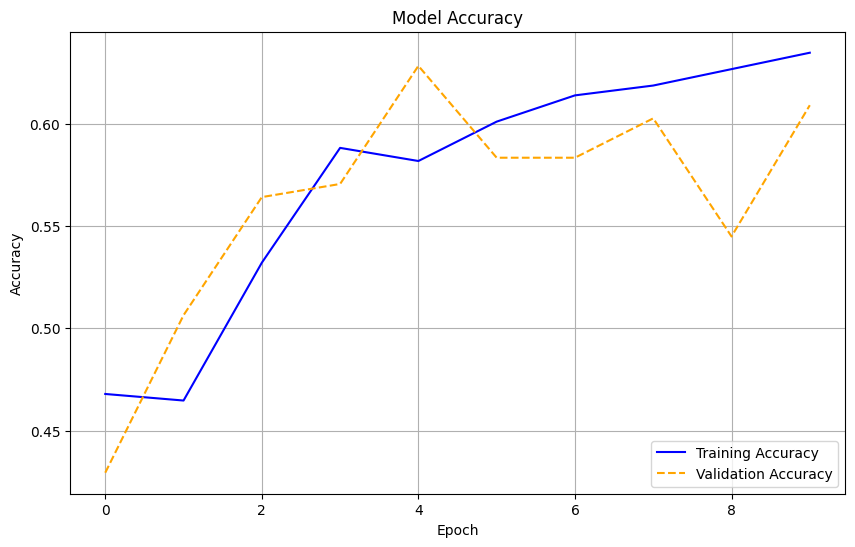

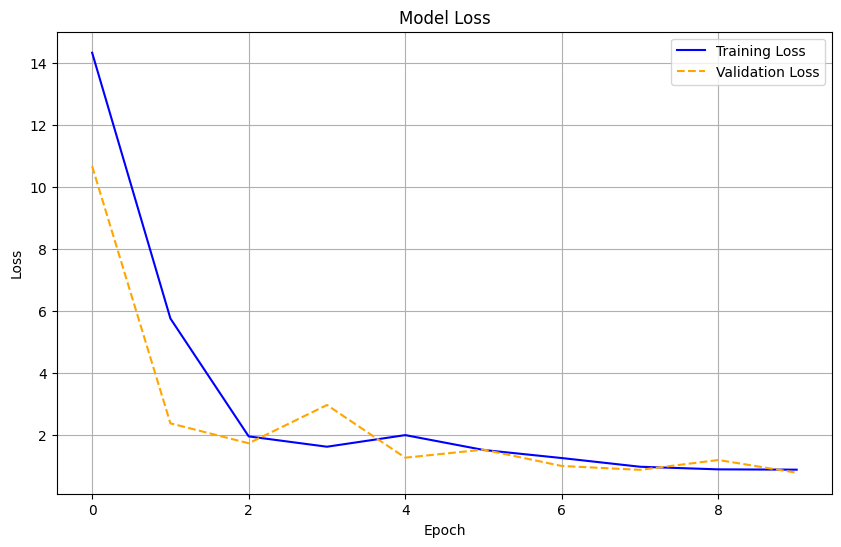

In [168]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('model_accuracy.png')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
